##  Digital Quantum Simulations of Time Evolution - Simulating the Heisenberg Chain


<p style='text-align: justify;'> In this section, we will use qiskit to program and run the digital quantum simulation of spin Hamiltonians. We will see at work many fundamental concepts, from the well known Trotter digitalization procedure to useful gate decompositions, and we will operatively test the capabilities of a quantum computer in solving the time evolution of a quantum system of interest.</p>

<p style='text-align: justify;'> In addition to qiskit, we will use some other well known python tools to do linear algebra calculations and to generate plots. All the required modules are imported below, together with the definition of some standard operators.</p>

In [1]:
from numpy import linspace, pi, abs, array, kron, zeros_like, real
from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, show, legend
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.opflow import CircuitSampler, PauliSumOp, StateFn, One, Zero, I, Z
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.quantum_info import SparsePauliOp
from scipy.linalg import expm
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False)

We will use the $XXX$ Heisenberg Hamiltonian $H_{\text{Heis}}$ as defined below

$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
\end{equation}
$$

$N$ is the number of spin-1/2 particles in model. The operators $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the usual Pauli operators where the $i$ and $j$ superscripts label which qubit they act on. For example, $\sigma_x^{(1)}$ would be the $\sigma_x$ operator acting on only qubit 1. This version of the general Heisenberg spin model is called $XXX$ because the same $J$ value multiplies each pair of Pauli operators. The sum notation $\langle ij \rangle$ means the sum is over nearest neighbors (only qubits next to each other interact), and $J$ is the interaction strength, which we will set $J=1$.

### Classical simulation of the Heisenberg chain

We can use Qiskit to have a classical simulation of the Heisenberg chain that we will use as a benchmark for the quantum computations.

In [2]:
 def HXXX(n):
    '''
    Matrix representation of the XXX Heisenberg model with `n` number of spin 1/2 particles.
    '''   
    # Using `SparsePauliOp` from `Terra` is very compact
    XXs = SparsePauliOp.from_sparse_list([["XX", [i, i + 1], 1] for i in range(n - 1)], n)
    YYs = SparsePauliOp.from_sparse_list([["YY", [i, i + 1], 1] for i in range(n - 1)], n)
    ZZs = SparsePauliOp.from_sparse_list([["ZZ", [i, i + 1], 1] for i in range(n - 1)], n)
    H = XXs + YYs + ZZs # Sum interactions

    return H # Return Hamiltonian

In [3]:
def UXXX(n, t):
    '''
    Unitary evolution operator  with `n` number of spin 1/2 particles.
    '''
    # Using `PauliSumOp` for future compatibility
    H = PauliSumOp(HXXX(n)) # Compute XXX Hamiltonian 
    
    return (t * H).exp_i() # Return the exponential of `-i` times `t` multipled Hamiltonian 

### Quantum simulation of the Heisenberg chain
### Part I: The 2 spins case

For the 2 spins case the Hamiltonian has the following form:

$$
H_{\text{Heis2}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}
$$

where we notice that the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. 

This means that the exponential decomposition using Trotterization of a 2 spins Hamiltonian ($H_{\text{Heis2}}$) is exact and gets us closer to a gate implementation of $U_{\text{Heis2}}(t)$

$$
\begin{align}
U_{\text{Heis2}}(t) &= \exp\left(-itH_{\text{Heis2}}\right) \\
 &= \exp\left(-it\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(-it\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(-it\sigma_z^{(0)}\sigma_z^{(1)}\right) 
\end{align}
$$



notice that, Qiskit already includes these operations, but we will see how we can construct the three operations using only  universal set of operations containing:
 - single qubit rotations,
 - the $\mathrm{CNOT}$ gate,
    
since this is what is natively implemented on the IBMQ devices, but other choices are of course equally valid from a mathematical perspective. 

The simplest transformation to implement is perhaps the so called $\mathrm{ZZ}(\delta)$:
$$
\mathrm{ZZ}(\delta) = e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}
$$
and, up to a global phase factor, which can be disregarded when working with quantum states, it corresponds to a combination of two $\mathrm{CNOT}$ gates and a single phase gate (which is called $\mathrm{U}(\lambda)$ in qiskit)
$
\mathrm{ZZ}(\delta) \rightarrow \mathrm{CNOT}(q_c,q_t) \left(\mathcal{I}_{q_c}\otimes\mathrm{U}(-2\delta)_{q_t}\right) \mathrm{CNOT}(q_c,q_t)
$.



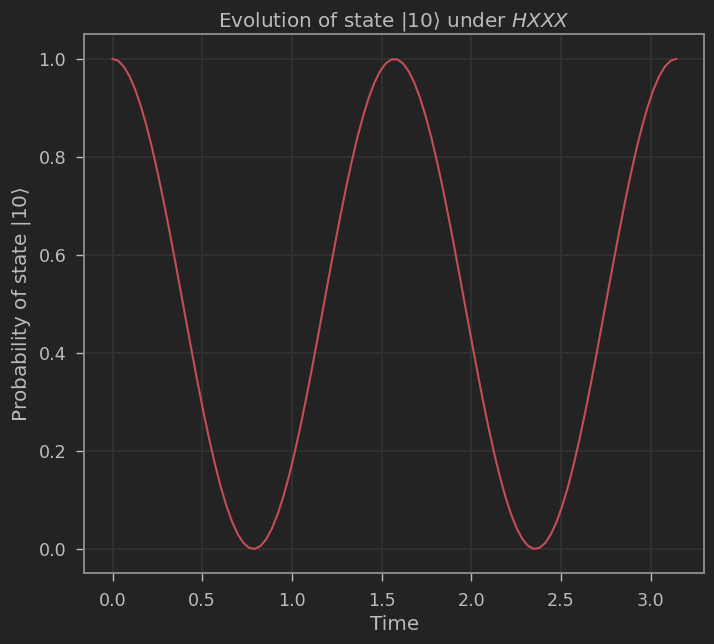

In [5]:
# First, create a classical simulation to compare
# Define array of time points
time = linspace(0, pi, 100)
number = 2
initial_state = Zero ^ One
probability_two = [abs((~initial_state @ UXXX(number, float(t)) @ \
                    initial_state).eval()) ** 2 for t in time]

# Plot evolution of |110>
plot(time, probability_two, '-r')
xlabel('Time')
ylabel(r'Probability of state $|10\rangle$')
title(r'Evolution of state $|10\rangle$ under $HXXX$')
grid()
show()

We will start from the $R_{ZZ}(\theta)$ rotation gate.

Once this gate is decomposed, we can act on the two qubits with $R_{Y}$ and $R_{X}$ to construct $R_{XX}$ and $R_{YY}$, respectively.

The $R_{ZZ}(\theta)$ is a two qubit gate with the following structure:

$$
\begin{aligned}
R_{ZZ}(\theta) &= \cos(\theta) I \otimes I - i\sin(\theta) Z \otimes Z \\&= 
\begin{bmatrix}
\cos(\theta)- i\sin(\theta) & 0 & 0 & 0 \\
0 & \cos(\theta)+ i\sin(\theta) & 0 & 0 \\
0 & 0 & \cos(\theta)+ i\sin(\theta) & 0 \\
0 & 0 & 0 & \cos(\theta)- i\sin(\theta)
\end{bmatrix}
\end{aligned}
$$

and, since there are only diagonal elements, we can start from a single qubit rotation $R_{Z} =\cos(\theta) I - i\sin(\theta) Z$, which is already diagonal

$$
I \otimes R_{Z}(\theta) = 
\begin{bmatrix}
\cos(\theta)- i\sin(\theta) & 0 & 0 & 0 \\
0 & \cos(\theta)+ i\sin(\theta) & 0 & 0 \\
0 & 0 & \cos(\theta)- i\sin(\theta) & 0 \\
0 & 0 & 0 & \cos(\theta)+ i\sin(\theta)
\end{bmatrix}
$$

and then invert the third and the fourth element of the diagonal.
We can switch 3rd and 4th rows by multiplying this matrix by a CNOT and then switch 3rd and 4th columns by multiplying the result by another $CNOT$ (see the $CNOT$ definition in the lecture note).

The final result is therefore $CNOT_{12}\cdot I \otimes R_{Z}(\theta)\cdot CNOT_{12}$ which we use to implement this operation on the real device.

In [6]:
def ZZ(t):
	'''
	Circuit of the ZZ rotation with parameter `t`.
	'''
	register = QuantumRegister(2)
	circuit = QuantumCircuit(register, name = 'ZZ')
	circuit.cnot(0, 1)
	circuit.rz(2 * t, 1) # Rotations are defined as `R(t) = e^(- i * t/2)` in Qiskit
	circuit.cnot(0, 1)

	return circuit

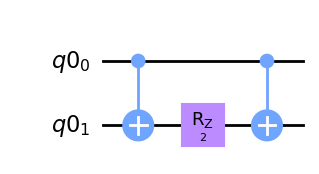

In [7]:
ZZ(1).draw("mpl")

Now we can apply a basis change using 
$$
R_{Y}(\theta) = \exp\left(-i \frac{\theta}{2} Y\right) =
            \begin{pmatrix}
                \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
                \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
            \end{pmatrix}
$$

then apply $R_{ZZ}$ and change the basis back to the original in order to apply the $R_{XX}$.

In particular

$$
R_{Y}(\pi/2) = \frac{1}{\sqrt{2}}
            \begin{pmatrix}
                1 & -1 \\
                1 & 1
            \end{pmatrix}
$$

and $R_{Y}(\pi/2) Z R_{Y}(-\pi/2) = X$, $R_{Y}(\pi/2) R_{Y}(-\pi/2) = I$.

So we have:

$$
R_{XX}(\theta)= \cos(\theta) I \otimes I - i\sin(\theta) X \otimes X = R_Y(\pi / 2)\otimes R_Y(\pi / 2) \cdot R_{ZZ}(\theta) \cdot R_Y(-\pi / 2)\otimes R_Y(-\pi / 2)
$$

that we can implement.

In [8]:
def XX(t):
	'''
	Circuit of the XX rotation with parameter `t`.
	''' 
	register = QuantumRegister(2)
	circuit = QuantumCircuit(register, name = 'XX')
	circuit.ry(pi / 2, [0, 1])
	circuit.cnot(0, 1)
	circuit.rz(2 * t, 1)
	circuit.cnot(0, 1)
	circuit.ry(-pi / 2, [0, 1])

	return circuit

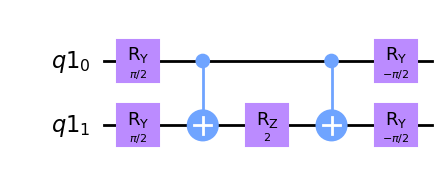

In [9]:
XX(1).draw("mpl")

And a similar procedure for $R_{YY}$ with

$$
R_{X}(\theta) = \exp\left(-i \frac{\theta}{2} X\right) =
            \begin{pmatrix}
                \cos{\frac{\theta}{2}}   & -i\sin{\frac{\theta}{2}} \\
                -i\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
            \end{pmatrix}
$$

and one can verify it leads to the correct result.

In [10]:
def YY(t):
	'''
	Circuit of the YY rotation with parameter `t`.
	''' 
	register = QuantumRegister(2)
	circuit = QuantumCircuit(register, name = 'YY')
	circuit.rx(pi / 2, [0, 1])
	circuit.cnot(0, 1)
	circuit.rz(2 * t, 1)
	circuit.cnot(0, 1)
	circuit.rx(-pi / 2, [0, 1])

	return circuit

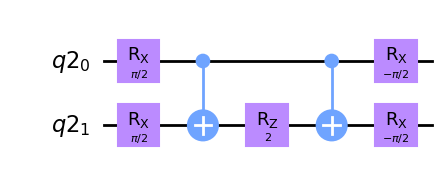

In [11]:
YY(1).draw("mpl")

The overall sequence required to simulate the Heisenberg dimer is
$
e^{-i\mathrm{H}t} = \mathrm{XX}(\delta)\mathrm{YY}(\delta)\mathrm{ZZ}(\delta)
$.

In [12]:
# Define where you want to run the circuit
backend = Aer.get_backend("statevector_simulator") # Exact
# backend = QasmSimulator(shots = 8000) # Shots
# backend = QasmSimulator(noise_model = noise_model, shots = 8000) # Noisy

expectation = PauliExpectation() 
sampler = CircuitSampler(backend)

# We want to measure |10><10| and |0><0|= (1/2)*(I+Z), |1><1|= (1/2)*(I-Z)
projector = StateFn((1 / 4) * ((I - Z) ^ (I + Z)), is_measurement = True)
probabilities = []

for t in time:
    # Prepare: at each time instant we need to create a new quantum circuit with a different
    # rotation parameter, this is pretty expensive from the computational point of view
    circuit = QuantumCircuit(2)
    circuit.x(1)
    circuit = circuit.compose(XX(t))
    circuit = circuit.compose(YY(t))
    circuit = circuit.compose(ZZ(t))
    
    # Measure: we need to take the expectation and convert it to the observable that we are 
    # looking for, that is the overlap on the initial state in this case (and not Z).
    trott_expect  = expectation.convert(projector @ StateFn(circuit))
    trott_sample  = sampler.convert(trott_expect)
    probabilities.append(trott_sample.eval().real)

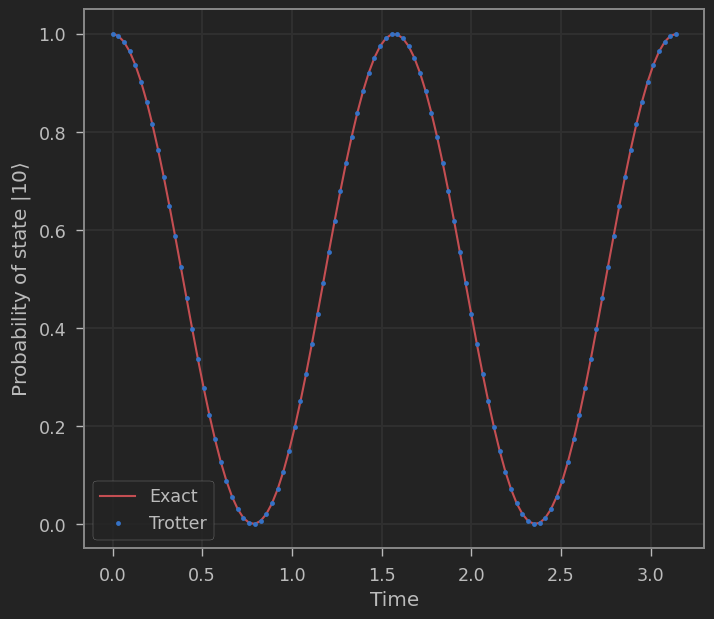

In [13]:
# Now plot the comparison
plot(time, probability_two, '-r', label = 'Exact')
plot(time, probabilities, '.b', label = 'Trotter')
xlabel('Time')
ylabel(r'Probability of state $|10\rangle$')
legend()
grid()
show()

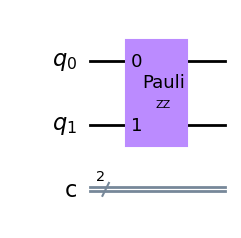

In [14]:
# Alternatively
from qiskit.quantum_info.operators import Operator, Pauli
x = Operator(Pauli('X'))
y = Operator(Pauli('Z'))
z = Operator(Pauli('Y'))
i = Operator(Pauli('I'))

# Add to a circuit
example = QuantumCircuit(2, 2)
example.append(Pauli('ZZ'), [0, 1])
example.draw(output = 'mpl')

### Computing Magnetization

By adding at the end of the circuit a measurement in the computational basis, we get an estimate of the probabilities $p_0^{(i)},p_1^{(i)}$ of finding each qubit in one of the two eigenstates of $\sigma_z$ (i.e. $\left|0\right\rangle$ and $\left|1\right\rangle$).
Therefore, we get an estimate of the average spin magnetization along the $z$ direction
$$
\left\langle\hat{s}^{(i)}_z(t)\right\rangle = \frac{1}{2}\left\langle\psi (t)\right|\sigma^{(i)}_z(t)\left|\psi(t)\right\rangle = \frac{1}{2}\left(p_0^{(i)} + (-1) p_1^{(i)}\right)
$$
where $\left|\psi(t)\right\rangle = U(t)\left|\psi (0)\right\rangle$ is the time evolved state of the two qubits. In order to obtain a non-trivial time evolution for $\left\langle\hat{s}^{(i)}_z(t)\right\rangle$, we will start from the initial state
$
\left|\psi (0) \right\rangle = \left|1\right\rangle \otimes \left|0\right\rangle
$.

You can find below the python code that compares the classical simulation of the Heisenberg dimer model with standard linear algebra techniques and the corresponding digital quantum simulation. Take a moment to understand the code, to play around with the parameters (including the number of repetitions of the quantum sequence) and to appreciate the agreement between the two techniques.  


In [15]:
J = 1

In [16]:
# Classical simulation of the Heisenberg dimer model
ctime = linspace(0, 0.5 * pi / abs(J), 1000)

# Preparation of physical quantity: writing the single qubit operators, that is the Pauli matrices
i = array([[1, 0],[0, 1]], dtype = complex) 
x = array([[0, 1],[1, 0]], dtype = complex) 
z = array([[1, 0],[0, -1]], dtype = complex) 
y = array([[0, -1j], [1j, 0]], dtype = complex) 

# Writing the two qubit operators
za = kron(z, i)
zb = kron(i, z)

# Initial state definition and execution
zero = array([1, 0], dtype = complex)
one = array([0, 1], dtype = complex)
psio = kron(one, zero) # Initial state
H = J * (kron(x, x) + kron(y, y) + kron(z, z)) # Hamiltonian

# Data structures to contain the measures
zac = zeros_like(ctime)
zbc = zeros_like(ctime)

for i, t in enumerate(ctime):
    psit = expm(-1j * H * t) @ psio
    zac[i] = real(psit.conjugate().transpose() @ za @ psit)
    zbc[i] = real(psit.conjugate().transpose() @ zb @ psit)

In [17]:
# Digital quantum simulation of the Heisenberg dimer model using qiskit
qtime = linspace(0, 0.5 * pi / abs(J), 100)
shots = 8000
backend = QasmSimulator(shots = shots)  
zaq = zeros_like(qtime)
zbq = zeros_like(qtime)

# Run the quantum algorithm
for i, t in enumerate(qtime):
    # Prepare 
    circuit = QuantumCircuit(2)
    circuit.x(1)
    circuit = circuit.compose(XX(t))
    circuit = circuit.compose(YY(t))
    circuit = circuit.compose(ZZ(t))

    # Measure: this time we only need to measure the state
    circuit.measure_all()
    
    # Run the quantum algorithm
    job = execute(circuit, backend)
    result = job.result()
    counts = result.get_counts()
    
    # Post processing of outcomes to get `z` expectation values: we have some counts which give
    # the probability of |0> and other which give the probability of |1>
    a = 0
    b = 0

    for key, value in counts.items():
        if key == '00': # If the state is |0> the expectation value on both the qubits increases
            a += value
            b += value
        elif key == '01':
            a -= value
            b += value
        elif key == '10':
            a += value
            b -= value
        elif key == '11':
            a -= value
            b -= value

    zaq[i] = a / shots
    zbq[i] = b / shots

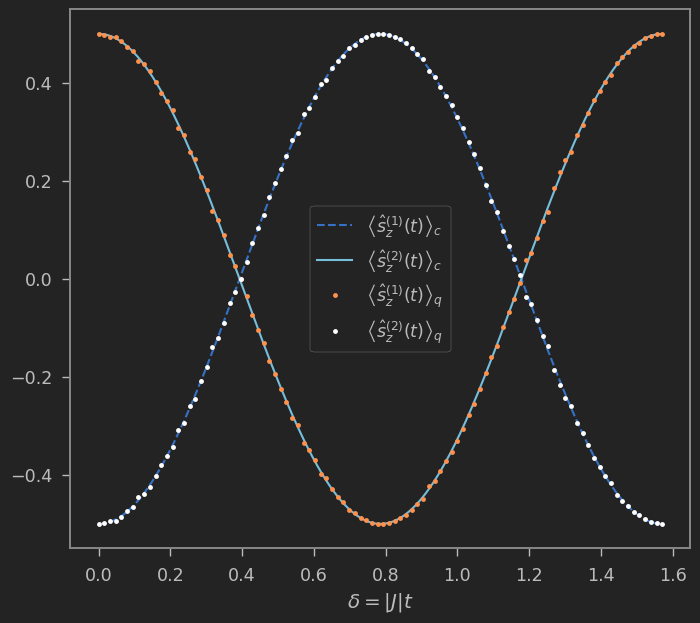

In [18]:
plot(abs(J) * ctime, zac * 0.5, 'b--')
plot(abs(J) * ctime, zbc * 0.5, 'c')
plot(abs(J) * qtime, zaq * 0.5, 'y.')
plot(abs(J) * qtime, zbq * 0.5, 'w.')
legend([r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle_c$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle_c$',
        r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle_q$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle_q$'])
xlabel(r'$\delta = |J|t$')
show()

Some reference to move to more difficult scenario with Trotterization: https://qiskit.org/documentation/stubs/qiskit.opflow.evolutions.html